In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('final_data_finale4.csv')

In [2]:
# Function to find the closest temperature and return the corresponding Cp value
def find_closest_cp(temp, cp_table):
    cp_table['Temp_diff'] = abs(cp_table['T'] - temp)
    closest_row = cp_table.loc[cp_table['Temp_diff'].idxmin()]
    return closest_row['Cp']

# Create Cp tables for Y2O3 and ZrO2
cp_y2o3 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1330, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [102.5, 102.8, 113.0, 118.1, 121.1, 123.2, 124.7, 125.9, 127.0, 127.9, 128.8, 129.6, 129.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 137.6, 152.4, 151.8, 160.1, 161.1]
})

cp_zro2 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1478, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [56.1, 56.3, 63.8, 67.6, 70.2, 72.0, 73.5, 74.7, 75.7, 76.6, 77.7, 78.6, 79.5, 80.8, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 87.9, 80.8, 78.6, 75.1, 74.5]
})


temp_column = 'Mean Particle Temperature (°C)'  # Assuming this is the column for temperature
x = 0.8  # Proportion for Y2O3

# Add the new Cp column to the dataset
data['Cp'] = data[temp_column].apply(lambda temp: (1 - x) * find_closest_cp(temp, cp_zro2) + x * find_closest_cp(temp, cp_y2o3))

data.head()

,Ar (SLM),N2 (SLM),H2 (SLM),Mean Particle Temperature (°C),Mean Particle Velocity (m/s),enthalpy,BP(°C),PS,MP,SPC,Cp
0,128.0,56.0,16.0,2447.5,387.2,9.7,100.0,3.34,2700,0.625,120.34
1,98.0,86.0,16.0,2506.8,379.9,12.0,100.0,3.34,2700,0.625,120.34
2,108.0,56.0,36.0,2546.0,383.2,9.8,100.0,3.34,2700,0.625,120.34
3,78.0,86.0,36.0,2517.6,379.8,7.8,100.0,3.34,2700,0.625,120.34
4,118.0,26.0,56.0,2481.8,340.1,6.9,100.0,3.34,2700,0.625,120.34


In [ ]:
X = data[['Ar (SLM)', 'N2 (SLM)', 'H2 (SLM)', 'Mean Particle Temperature (°C)','BP(°C)','PS','Cp']]
y_velocity = data['Mean Particle Velocity (m/s)']
y_enthalpy = data['enthalpy']

In [6]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = data[['Ar (SLM)', 'N2 (SLM)', 'H2 (SLM)', 'Mean Particle Temperature (°C)','BP(°C)','PS','Cp']]
y_velocity = data['Mean Particle Velocity (m/s)']
y_enthalpy = data['enthalpy']

# Split the data into training and testing sets for both targets
X_train, X_test, y_velocity_train, y_velocity_test, y_enthalpy_train, y_enthalpy_test = train_test_split(
    X, y_velocity, y_enthalpy, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for Ridge regression
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

# Initialize the Ridge regression model
ridge = Ridge()

# Initialize GridSearchCV for both targets
grid_search_velocity = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_enthalpy = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the models using grid search
grid_search_velocity.fit(X_train_scaled, y_velocity_train)
grid_search_enthalpy.fit(X_train_scaled, y_enthalpy_train)

# Get the best parameters
best_params_velocity = grid_search_velocity.best_params_
best_params_enthalpy = grid_search_enthalpy.best_params_

# Predict on the test data using the best models
y_velocity_pred = grid_search_velocity.best_estimator_.predict(X_test_scaled)
y_enthalpy_pred = grid_search_enthalpy.best_estimator_.predict(X_test_scaled)

# Calculate MAE for both models
mae_velocity = mean_absolute_error(y_velocity_test, y_velocity_pred)
mae_enthalpy = mean_absolute_error(y_enthalpy_test, y_enthalpy_pred)

# Print the results
print("Best parameters for velocity prediction:", best_params_velocity)
print("Best R² score for velocity prediction:", grid_search_velocity.best_score_)
print("MAE for velocity prediction:", mae_velocity)

print("Best parameters for enthalpy prediction:", best_params_enthalpy)
print("Best R² score for enthalpy prediction:", grid_search_enthalpy.best_score_)
print("MAE for enthalpy prediction:", mae_enthalpy)


Best parameters for velocity prediction: {'alpha': 1.0, 'fit_intercept': True, 'solver': 'sag'}
Best R² score for velocity prediction: 0.9299316672309936
MAE for velocity prediction: 16.290336236187738
Best parameters for enthalpy prediction: {'alpha': 10.0, 'fit_intercept': True, 'solver': 'svd'}
Best R² score for enthalpy prediction: 0.726037718732467
MAE for enthalpy prediction: 0.6022619861357054


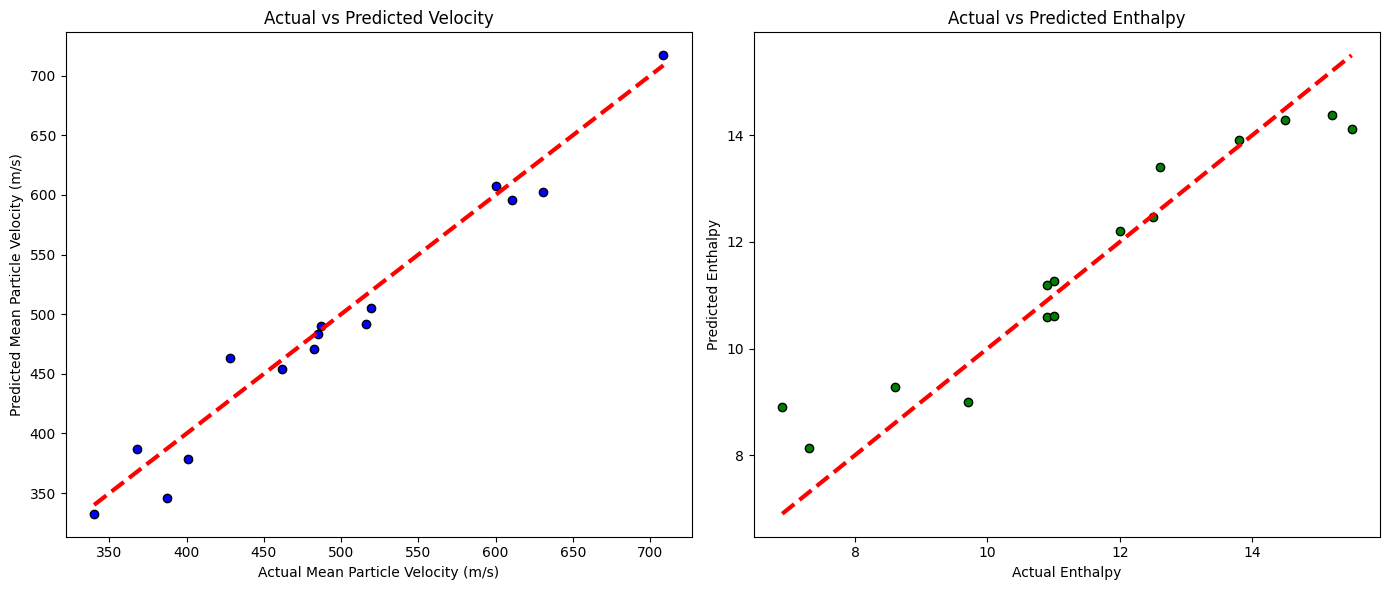

In [8]:
import matplotlib.pyplot as plt
# Plot predictions vs actuals for velocity
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_velocity_test, y_velocity_pred, color='blue', edgecolor='k')
plt.plot([y_velocity_test.min(), y_velocity_test.max()], [y_velocity_test.min(), y_velocity_test.max()], 'r--', lw=3)
plt.xlabel('Actual Mean Particle Velocity (m/s)')
plt.ylabel('Predicted Mean Particle Velocity (m/s)')
plt.title('Actual vs Predicted Velocity')

# Plot predictions vs actuals for enthalpy
plt.subplot(1, 2, 2)
plt.scatter(y_enthalpy_test, y_enthalpy_pred, color='green', edgecolor='k')
plt.plot([y_enthalpy_test.min(), y_enthalpy_test.max()], [y_enthalpy_test.min(), y_enthalpy_test.max()], 'r--', lw=3)
plt.xlabel('Actual Enthalpy')
plt.ylabel('Predicted Enthalpy')
plt.title('Actual vs Predicted Enthalpy')

plt.tight_layout()
plt.show()

In [9]:
model_velocity = grid_search_velocity.best_estimator_

In [10]:
model_enthalpy = grid_search_enthalpy.best_estimator_

In [28]:
def predict_custom_input(model_velocity, model_enthalpy, scaler, input_data):

    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Standardize the input data
    input_scaled = scaler.transform(input_df)
    
    # Make predictions
    predicted_velocity = model_velocity.predict(input_scaled)
    predicted_enthalpy = model_enthalpy.predict(input_scaled)
    
    return predicted_velocity[0], predicted_enthalpy[0]

# Example usage
custom_input = {
    'Ar (SLM)': 221.63,                          # example value for Argon gas flow rate
    'N2 (SLM)': 39,                           # example value for Nitrogen gas flow rate
    'H2 (SLM)': 18,                           # example value for Hydrogen gas flow rate
    'Mean Particle Temperature (°C)': 2858.84,   # example temperature value
    'BP(°C)': 78.37,                            # example value for Boiling Point
    'PS': 0.45,                               # example value for PS
    'Cp': 120.34                             # example value for Cp
}

# Predict using the best models from the grid search
predicted_velocity, predicted_enthalpy = predict_custom_input(
    model_velocity=grid_search_velocity.best_estimator_,
    model_enthalpy=grid_search_enthalpy.best_estimator_,
    scaler=scaler,
    input_data=custom_input
)

print(f"Predicted Mean Particle Velocity (m/s): {predicted_velocity}")
print(f"Predicted Enthalpy: {predicted_enthalpy}")


Predicted Mean Particle Velocity (m/s): 585.4377205970882
Predicted Enthalpy: 9.11123089774619
